# Rotary Spectra

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import netcdf
from scipy import signal

In [2]:
fpath = '/gscratch/jisao/mclaret/GL64/Juin_Novembre/'
gridU_k1 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridU_k1.nc','r')
gridV_k1 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridV_k1.nc','r')
gridU_k58 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridU_k58.nc','r')
gridV_k58 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridV_k58.nc','r')

In [3]:
# verify data shapes
if gridU_k1.variables['vozocrtx'].shape == gridV_k1.variables['vomecrty'].shape:
    print('k1 component shapes match.')
else:
    print('k1 component shapes do not match.')

if gridU_k58.variables['vozocrtx'].shape == gridV_k58.variables['vomecrty'].shape:
    print('k58 component shapes match.')
else:
    print('k58 component shapes do not match.')

k1 component shapes match.
k58 component shapes match.


In [4]:
# coordinates to focus on
x=275; y=48; t0=0; t1=3648-1  # S1 eddy
#x=321; y=100; t0=0; t1=3648-1  # S2 eddy
#x=347; y=54; t0=0; t1=3648-1  # S3 eddy

# variables at k=1
nav_lon = gridU_k1.variables['nav_lon'][y-1, x-1].copy()          # longitude
nav_lat = gridU_k1.variables['nav_lat'][y-1, x-1].copy()          # latitude
U_k1 = gridU_k1.variables['vozocrtx'][t0:t1, 0, y-1, x-1].copy()  # zonal velocities
V_k1 = gridV_k1.variables['vomecrty'][t0:t1, 0, y-1, x-1].copy()  # meridional velocities

# variables at k=58
U_k58 = gridU_k58.variables['vozocrtx'][t0:t1, 0, y-1, x-1].copy()  # zonal velocities
V_k58 = gridV_k58.variables['vomecrty'][t0:t1, 0, y-1, x-1].copy()  # meridional velocities

gridU_k1.close()
gridV_k1.close()
gridU_k58.close()
gridV_k58.close()

In [5]:
# surface parameters
maxt_k1 = len(U_k1)
dt = 1.0  # 1-hour resolution
T_k1 = (maxt_k1-1)*dt
times_k1 = np.arange(1,maxt_k1+1,1) * 1.0
print('maxt = ', maxt_k1)
print('times = ', times_k1)

maxt =  3647
times =  [1.000e+00 2.000e+00 3.000e+00 ... 3.645e+03 3.646e+03 3.647e+03]


In [6]:
omega = 7.2921e-5
fCor = 2.*omega*np.sin((nav_lat)/180*np.pi)  # radians/sec
Tip = ((1./fCor) / 3600) * (2*np.pi)         # hours/cycle

print('fCor =', fCor)
print('Tip =', Tip)

fCor = 9.758121217882337e-05
Tip = 17.885914850042138


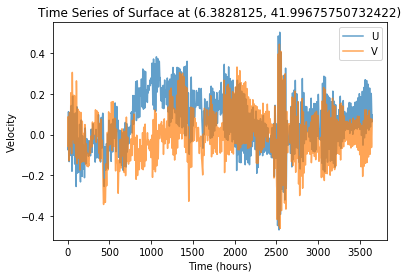

In [7]:
# plot time series of U and V at surface
plt.figure()
plt.plot(times_k1, U_k1, label='U', alpha=0.7)
plt.plot(times_k1, V_k1, label='V', alpha=0.7)
#plt.xlim(0,400)

# plot labels
plt.title('Time Series of Surface at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Time (hours)')
plt.ylabel('Velocity')
plt.legend()
plt.show()

In [8]:
alpha=0.2

# Tapered cosine windows for surface data
win1_k1 = signal.tukey(len(U_k1),0)      # rectangular window
win2_k1 = signal.tukey(len(U_k1),1)      # Hann window
win3_k1 = signal.tukey(len(U_k1),alpha)  # 20% of points

In [9]:
# find amplitudes of surface Fourier coefficients
hvel_k1 = U_k1 + 1j*V_k1
fc_k1 = np.fft.fft(hvel_k1*win3_k1)  # k1 Fourier coefficients (FCs) w/ window
amp_k1 = np.abs(fc_k1)**2            # amplitude of k1 FCs
print(amp_k1)

fq_k1 = np.fft.fftfreq(times_k1.shape[-1],dt)  # frequencies corresponding to each FC (cycles/h)
fq_k1_norm = fq_k1*2*np.pi/fCor/3600           # normalized to coriolis frequency

# rearrange data for plotting
amp_k1 = np.fft.fftshift(amp_k1)
fq_k1_norm = np.fft.fftshift(fq_k1_norm)

[50679.50724716 44466.40003364 37157.13583879 ...  1767.3819908
  5046.0230168   7128.28062725]


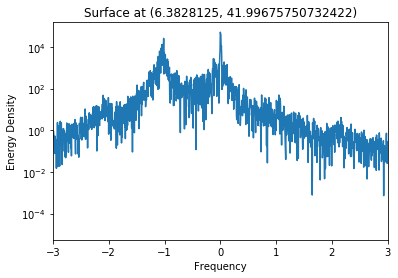

In [10]:
# plot rotary spectrum at k1
plt.figure()
plt.plot(fq_k1_norm, amp_k1)
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('Surface at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
plt.show()

In [11]:
# 500m parameters
maxt_k58 = len(U_k58)
dt = 1.0  # 1-hour resolution
T_k58 = (maxt_k58-1)*dt
times_k58 = np.arange(1,maxt_k58+1,1) * 1.0
print('maxt = ', maxt_k58)
print('times = ', times_k58)

maxt =  3647
times =  [1.000e+00 2.000e+00 3.000e+00 ... 3.645e+03 3.646e+03 3.647e+03]


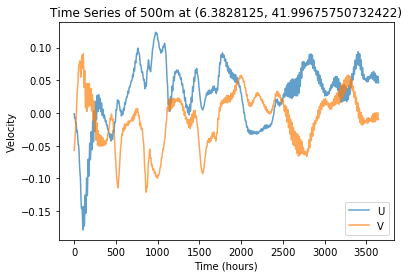

In [12]:
# plot time series of U and V at 500m
plt.figure()
plt.plot(times_k58, U_k58, label='U', alpha=0.7)
plt.plot(times_k58, V_k58, label='V', alpha=0.7)
#plt.xlim(0,400)

# plot labels
plt.title('Time Series of 500m at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Time (hours)')
plt.ylabel('Velocity')
plt.legend()
plt.show()

In [13]:
alpha=0.2

# Tapered cosine windows for 500m data
win1_k58 = signal.tukey(len(U_k58),0)      # rectangular window
win2_k58 = signal.tukey(len(U_k58),1)      # Hann window
win3_k58 = signal.tukey(len(U_k58),alpha)  # 20% of points

In [14]:
# find amplitudes of 500m Fourier coefficients
hvel_k58 = U_k58 + 1j*V_k58
fc_k58 = np.fft.fft(hvel_k58*win3_k58)  # k58 Fourier coefficients (FCs) w/ window
amp_k58 = np.abs(fc_k58)**2             # amplitude of k58 FCs
print(amp_k58)

fq_k58 = np.fft.fftfreq(times_k58.shape[-1],dt)  # frequencies corresponding to each FC (cycles/h)
fq_k58_norm = fq_k58*2*np.pi/fCor/3600           # normalized to coriolis frequency

# rearrange data for plotting
amp_k58 = np.fft.fftshift(amp_k58)
fq_k58_norm = np.fft.fftshift(fq_k58_norm)

[13241.12256617  3070.97208487  8720.06291331 ...   115.28395804
  1520.00774001   596.14177507]


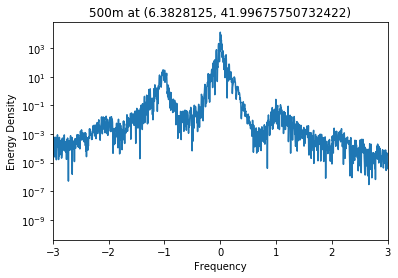

In [15]:
# plot rotary spectrum at k58
plt.figure()
plt.plot(fq_k58_norm, amp_k58)
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('500m at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
#plt.xscale('log')
plt.show()

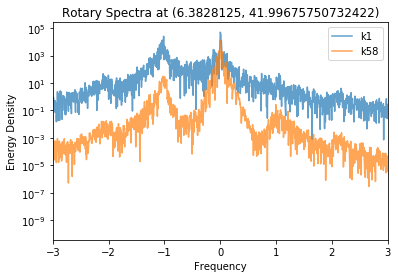

In [16]:
# plot both spectra on same figure
plt.figure()
plt.plot(fq_k1_norm, amp_k1, label='k1', alpha=0.7)
plt.plot(fq_k58_norm, amp_k58, label='k58', alpha=0.7)
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('Rotary Spectra at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()